In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

base_path = "/kaggle/input/paddy-disease-classification/train_images"
image_paths = []
labels = []

classes = sorted(os.listdir(base_path))
print("Detected classes:", classes)

for label in classes:
    folder_path = os.path.join(base_path, label)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

Detected classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [2]:
df.head()

,image_path,label
0,/kaggle/input/paddy-disease-classification/tra...,bacterial_leaf_blight
1,/kaggle/input/paddy-disease-classification/tra...,bacterial_leaf_blight
2,/kaggle/input/paddy-disease-classification/tra...,bacterial_leaf_blight
3,/kaggle/input/paddy-disease-classification/tra...,bacterial_leaf_blight
4,/kaggle/input/paddy-disease-classification/tra...,bacterial_leaf_blight


In [3]:
print(df.shape)
print(df.columns)
print(df.duplicated().sum())
print(df.isnull().sum())

(10407, 2)
Index(['image_path', 'label'], dtype='object')
0
image_path    0
label         0
dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10407 non-null  object
 1   label       10407 non-null  object
dtypes: object(2)
memory usage: 162.7+ KB


In [5]:
df['label'].value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

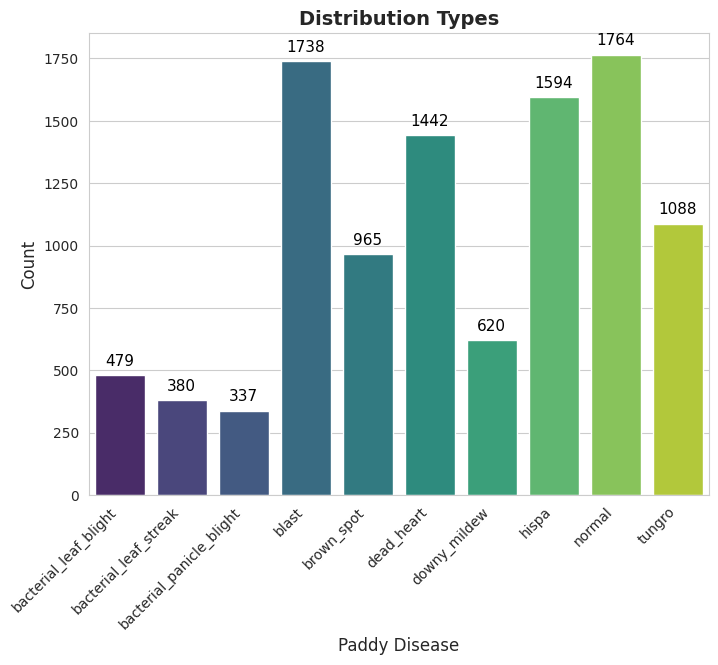

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution Types", fontsize=14, fontweight="bold")
ax.set_xlabel("Paddy Disease", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/ 2.,p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0,5), textcoords='offset points')
plt.show();

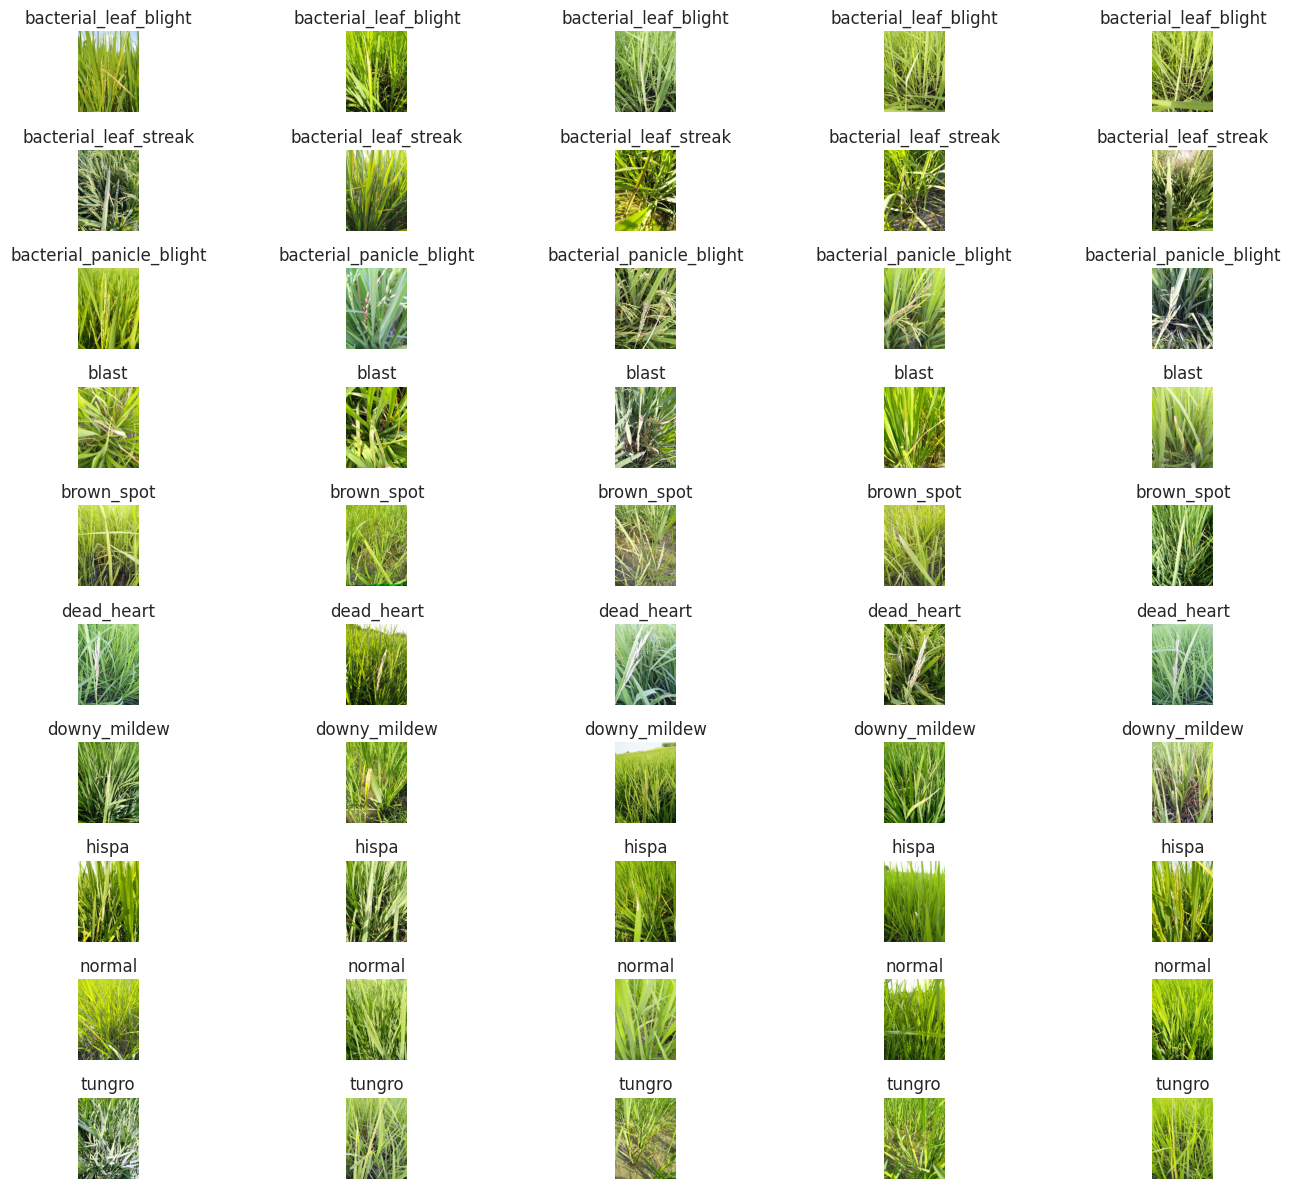

In [7]:
import cv2
import warnings
warnings.filterwarnings("ignore")

num_images = 5

plt.figure(figsize=(15,12))

for i, category in enumerate(classes):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), num_images,  i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show();

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['label'])
df['category_encoded'] = df['category_encoded'].astype(str)

df= df[["image_path","category_encoded"]]

class_label = {i: label for i, label in enumerate(le.classes_)}
print(class_label)


max_count = df["category_encoded"].value_counts().max()
dfs = []
for category in df['category_encoded'].unique():
    class_subset = df[df['category_encoded'] == category]
    class_upsampled = resample(class_subset, replace=True, n_samples = max_count, random_state = 42)
    dfs.append(class_upsampled)

df_balanced = pd.concat(dfs).sample(frac = 1, random_state = 42).reset_index(drop = True)
df_balanced['category_encoded'].value_counts()

df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)


{0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


In [9]:
df_resampled["category_encoded"].value_counts()

category_encoded
0    1764
9    1764
5    1764
2    1764
8    1764
4    1764
7    1764
6    1764
3    1764
1    1764
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size = 0.8,
    shuffle = True,
    random_state = 42,
    stratify = df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size = 0.5,
    shuffle = True,
    random_state = 42,
    stratify = temp_df_new['category_encoded']
)

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale = 1./255)

ts_gen = ImageDataGenerator(rescale = 1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)


2025-07-26 08:38:14.253753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753519094.454256      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753519094.512765      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 14112 validated image filenames belonging to 10 classes.
Found 1764 validated image filenames belonging to 10 classes.
Found 1764 validated image filenames belonging to 10 classes.


In [11]:
import tensorflow as tf
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is set for TensorFlow")
  except RuntimeError as e:
        print(e)


Number of GPUs Available: 1
GPU is set for TensorFlow


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Lambda, Conv2D, MaxPooling2D,
                                     Flatten, Dense, Reshape, Concatenate,
                                     GlobalAveragePooling1D, Softmax, Multiply, Dropout)
from tensorflow.keras.models import Model


num_classes = len(train_df_new['category_encoded'].unique())

In [13]:
def split_image(image):
    upper_half = image[:, :img_size[0]//2, :, :]
    lower_half = image[:, img_size[0]//2:, :, :]
    return upper_half, lower_half

def flip_lower_half(lower_half):
    return tf.image.flip_left_right(lower_half)

In [14]:
input_layer = Input(shape=img_shape)

upper_half, lower_half = Lambda(split_image)(input_layer)
lower_half_flipped = Lambda(flip_lower_half)(lower_half)

In [15]:
upper = Conv2D(16, (3, 3), activation='relu', padding='same')(upper_half)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(32, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(64, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Flatten()(upper)
upper = Dropout(0.5)(upper)
upper_dense = Dense(256, activation='relu')(upper)
upper_reshape = Reshape((1, 256))(upper_dense)

I0000 00:00:1753519139.804564      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
lower = Conv2D(16, (3, 3), activation='relu', padding='same')(lower_half_flipped)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(32, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(64, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Flatten()(lower)
lower = Dropout(0.5)(lower)
lower_dense = Dense(256, activation='relu')(lower)
lower_reshape = Reshape((1, 256))(lower_dense)

In [17]:
concat_seq = Concatenate(axis=1)([upper_reshape, lower_reshape])
similarity_scores = tf.keras.layers.Dot(axes=-1, normalize=True)([upper_reshape, lower_reshape])
attention_weights = Softmax(axis=1)(similarity_scores)
attended = Multiply()([attention_weights, upper_reshape])
combined = Concatenate(axis=-1)([attended, lower_reshape])
combined = Reshape((512,))(combined)
combined = Dropout(0.5)(combined)

In [18]:
fc1 = Dense(128, activation='relu')(combined)
fc2 = Dense(64, activation='relu')(fc1)
output = Dense(num_classes, activation='softmax')(fc2)

In [19]:
model = Model(inputs=input_layer, outputs=output)
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 112, 224, │          0 │ input_layer[0][0] │
│                     │ 3), (None, 112,   │            │                   │
│                     │ 224, 3)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 112, 224,  │          0 │ lambda[0][1]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 224,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 224,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 112,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 112,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 112,   │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 112,   │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 56,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 56,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_5[

 Total params: 12,967,306 (49.47 MB)

 Trainable params: 12,967,306 (49.47 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=15,
    batch_size=batch_size
)

Epoch 1/15


I0000 00:00:1753519146.377886     101 service.cc:148] XLA service 0x7fb608004490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753519146.378653     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753519146.933761     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/882 ━━━━━━━━━━━━━━━━━━━━ 2:18:45 9s/step - accuracy: 0.0000e+00 - loss: 2.3174

I0000 00:00:1753519150.975837     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


882/882 ━━━━━━━━━━━━━━━━━━━━ 128s 135ms/step - accuracy: 0.1471 - loss: 2.2394 - val_accuracy: 0.4223 - val_loss: 1.6612
Epoch 2/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 63s 71ms/step - accuracy: 0.4845 - loss: 1.4816 - val_accuracy: 0.7562 - val_loss: 0.8271
Epoch 3/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.7232 - loss: 0.8418 - val_accuracy: 0.8560 - val_loss: 0.4807
Epoch 4/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.8389 - loss: 0.4934 - val_accuracy: 0.9048 - val_loss: 0.3343
Epoch 5/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.8937 - loss: 0.3408 - val_accuracy: 0.9240 - val_loss: 0.2654
Epoch 6/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step - accuracy: 0.9183 - loss: 0.2533 - val_accuracy: 0.9354 - val_loss: 0.2373
Epoch 7/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 69s 78ms/step - accuracy: 0.9346 - loss: 0.2010 - val_accuracy: 0.9444 - val_loss: 0.2057
Epoch 8/15
882/882 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step - accuracy: 0.9461 - loss: 0.1631 - val_accur

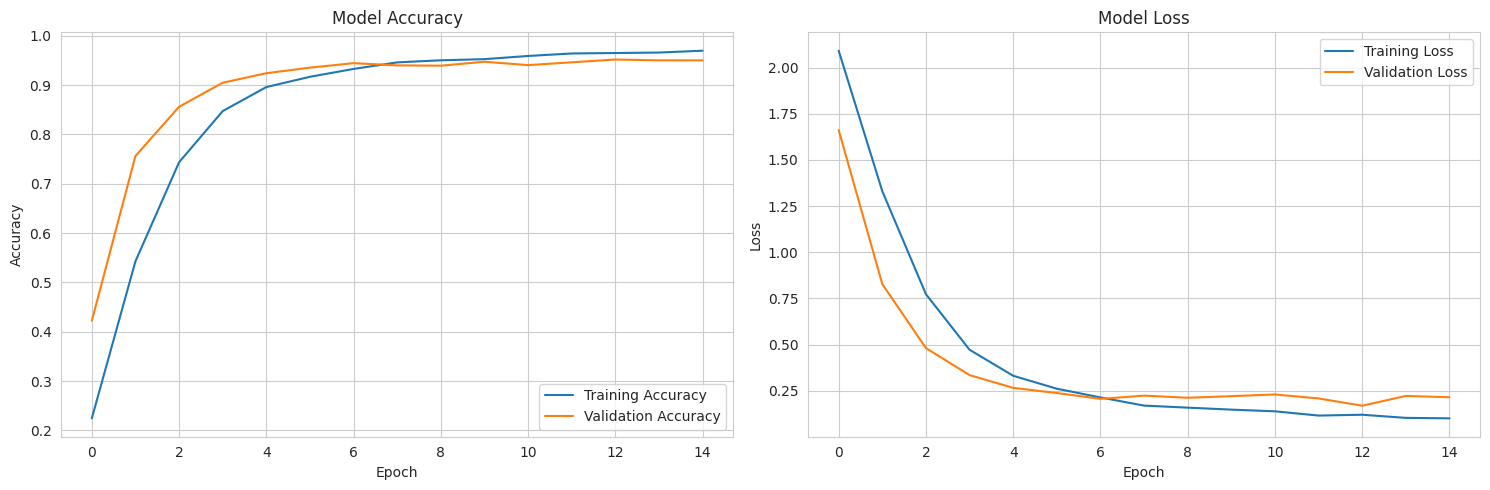

In [21]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['accuracy'], label='Training Accuracy')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)
  ax2.plot(history.history['loss'], label='Training Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)
  plt.tight_layout()
  plt.show()
plot_training_history(history)

In [22]:
print("Final Epoch Validation Accuracy: ", history.history['val_accuracy'][-1]*100)
print("Final Epoch Validation Loss: ", history.history['val_loss'][-1])

Final Epoch Validation Accuracy:  95.01133561134338
Final Epoch Validation Loss:  0.21460597217082977


In [23]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9591 - loss: 0.1686
Test Accuracy: 0.9518, Test Loss: 0.1969


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
test_gen_new.reset()
y_pred = model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step


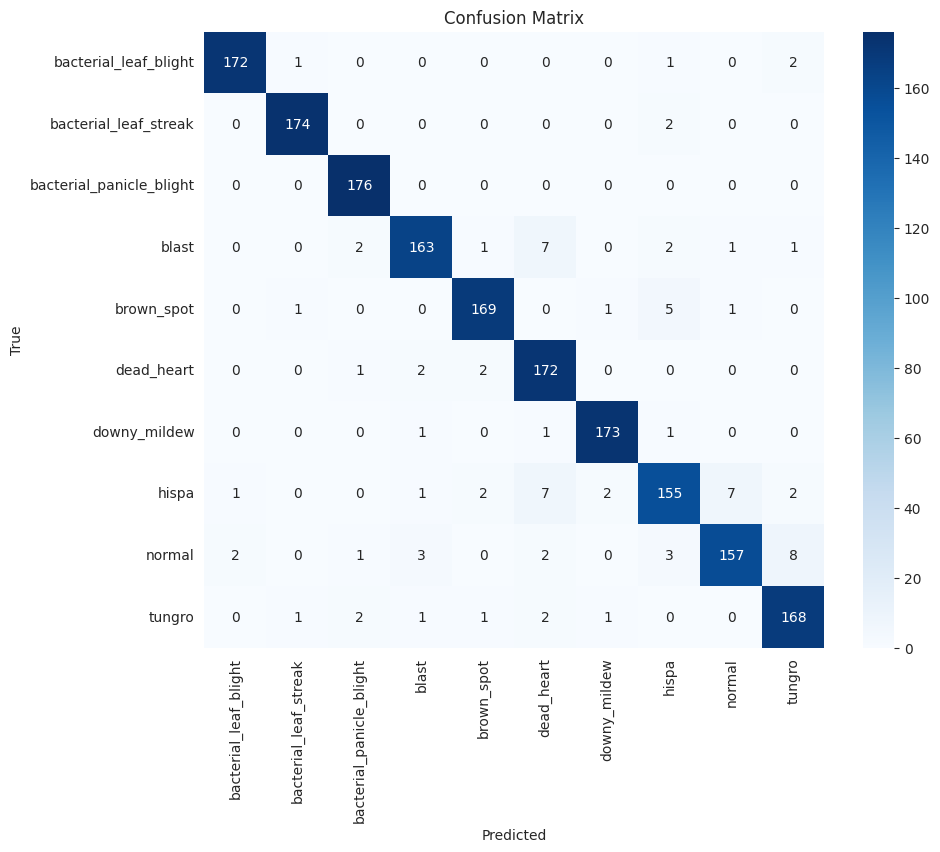

In [25]:
class_names = le.classes_

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
target_names=class_names))


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.98      0.98      0.98       176
   bacterial_leaf_streak       0.98      0.99      0.99       176
bacterial_panicle_blight       0.97      1.00      0.98       176
                   blast       0.95      0.92      0.94       177
              brown_spot       0.97      0.95      0.96       177
              dead_heart       0.90      0.97      0.93       177
            downy_mildew       0.98      0.98      0.98       176
                   hispa       0.92      0.88      0.90       177
                  normal       0.95      0.89      0.92       176
                  tungro       0.93      0.95      0.94       176

                accuracy                           0.95      1764
               macro avg       0.95      0.95      0.95      1764
            weighted avg       0.95      0.95      0.95      1764

